# Topic modeling example

This exercise introduces topic modeling using the LDA (Latent Dirichlet Allocation) algorithm and the Non-negative Matrix Factorisation (NMF) algorithm.

Topic modeling is an unsupervised approach that allows you to explore large text collections.

Written by: Sumithra Velupillai, with input from Sonia Priou, February 2019 

In [42]:
## First we need to import all the necessary packages

import string
from gensim import models
from gensim.corpora import Dictionary, MmCorpus
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import itertools
import zipfile

try:
    import pyLDAvis
except ImportError as e:
    !pip install pyldavis
    import pyLDAvis

import pyLDAvis.gensim as gensimvis
import os
import pandas as pd

import re
import codecs
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

import numpy as np
from sklearn.decomposition import NMF, LatentDirichletAllocation
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings; warnings.simplefilter('ignore')

from datetime import datetime
print(datetime.now())


2023-02-06 16:42:34.569543


[nltk_data] Downloading package punkt to /Users/lilifang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lilifang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1: Functions for LDA and NMF

In [43]:
def get_tfidf_model(dataframe, text_column, min_df = 5, max_df=100000):
    stopwords = nltk.corpus.stopwords.words('english')
    new_stopwords = ["um", "ok", "oh", "okay", "yes","get","mhm","yeah","ah","uh","no","hm","wow"]
    stopwords.extend(new_stopwords)
    min_df = 5
    max_df = 100000
    bow_transformer = CountVectorizer(stop_words=stopwords, 
                                  min_df=min_df, 
                                  max_df=max_df).fit(dataframe[text_column])
    document_bow = bow_transformer.transform(dataframe[text_column])
    feature_names = bow_transformer.get_feature_names()
    tfidf_transformer = TfidfTransformer().fit(document_bow)
    document_tfidf= tfidf_transformer.transform(document_bow)
    return feature_names, document_tfidf

In [44]:
def getNMFModel(no_topics, document_tfidf):
    nmf = NMF(n_components=no_topics, 
          random_state=1, 
          alpha=.1, 
          l1_ratio=.5, 
          init='nndsvd').fit(document_tfidf)

    W = nmf.transform(document_tfidf)
    H = nmf.components_
    return nmf, W, H

def getLDAModel(no_topics, document_tfidf):
    lda = LatentDirichletAllocation(n_components=no_topics).fit(document_tfidf)
    return lda

In [45]:
# We need a couple of functions to visualise the data
# Preparation for visualisation 
# Written by Sonia Priou, adaptations by Sumithra Velupillai

def display_topics(model, feature_names, no_top_words):
    topic_id_text_lis = [] 
    for topic_idx, topic in enumerate(model.components_):
        topic_id =topic_idx
        topic_keyword =" - ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        print(topic_id,topic_keyword)
        new_id_keywords = str(topic_id)+':'+topic_keyword
        topic_id_text_lis.append(new_id_keywords)
    return topic_id_text_lis

In [46]:

def get_topic_list(model, feature_names, no_top_words):
    tlist = {}
    for topic_idx, topic in enumerate(model.components_):
        tlist[topic_idx]= str("%d: " % (topic_idx)+", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
    return tlist

    
def display_topic_representation (model,dataframe,tlist):
    doc_topic = model    #example : model = lda_Tfidf.transform(tfidf)
    doc = np.arange(doc_topic.shape[0])
    num_topics = doc_topic.shape[1]
    dico = {'index': doc}
    for n in range(num_topics):
        dico["topic" + str(n)] = doc_topic[:,n]
    
    #Max topic 
    Topic_max = []
    for i in range(doc_topic.shape[0]):
        if len(set(doc_topic[i])) == 1:
            Topic_max.append(num_topics+1)
        else:
            Topic_max.append(doc_topic[i].argmax())
    dico["Topic most represented"] = Topic_max
    #print(Topic_max)
    tlist[num_topics+1] = 'NONE'
    dico["Topic and its most representative words"] = [tlist[x] for x in Topic_max]
    df_topic = pd.DataFrame(dico)

    
    #Link both DataFrame
    df_result = pd.merge(dataframe,df_topic, on='index')
    df_result = df_result.sort_values('Topic most represented')
    
    #Finding within the cluster found by LDA the original file
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    sns.set_style('whitegrid')
    sns.countplot(y='Topic and its most representative words', data = df_result)
    return df_result



In [47]:
def display_file_representation (model,dataframe):
    #Within a file, what is the slipt between topics found
    doc_topic = model    #example : model = lda_Tfidf.transform(tfidf)
    doc = np.arange(doc_topic.shape[0])
    no_topics = doc_topic.shape[1]
    topic = np.arange(no_topics)
    dico = {'index': doc}
    for n in range(no_topics):
        dico["topic" + str(n)] = doc_topic[:,n]
    #Max topic 
    Topic_max = []
    for i in range(doc_topic.shape[0]):
        Topic_max.append(doc_topic[i].argmax())
    dico["Topic most represented"] = Topic_max
    df_topic = pd.DataFrame(dico)
    #print(df_topic)
    
    
    #Link both DataFrame
    df_result = pd.merge(dataframe,df_topic, on='index')
    
    dico2 = {'Topic': topic}
    for i in df_result['label'].value_counts().index:
        ser = df_result.loc[df_result['label']==i].mean()
        score = ser[2:no_topics+2]
        dico2[i]=score

    df_score = pd.DataFrame(dico2)
    print('For each given file, we calculate the mean percentage of the documents depence to each topic')
    print('')
    print(df_score)
    print(df_result['label'].value_counts().index)

    fig, axs = plt.subplots(ncols=len(dataframe['label'].value_counts()))
    count = 0
    for i in df_result['label'].value_counts().index:
        sns.barplot(x='Topic', y =i ,data = df_score, ax=axs[count])
        count = count + 1
        
    plt.tight_layout()

In [48]:
def calculate_coherence( w2v_model, term_rankings , print_pairs=False):
        overall_coherence = 0.0
        for topic_index in range(len(term_rankings)):
            # check each pair of terms
            pair_scores = []
            for pair in combinations( term_rankings[topic_index], 2 ):
                ## check if word in vocabulary first!! Added by Sumithra
                if pair[0] in w2v_model.wv.index_to_key and pair[1] in w2v_model.wv.index_to_key:
                    pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]) )
                    if print_pairs:
                        print(pair[0], pair[1], w2v_model.wv.similarity(pair[0], pair[1]))
                else:
                    if print_pairs:
                        print('word pair not in vocabulary', pair[0], pair[1])
                    pair_scores.append( 0.0 )
            # get the mean for all pairs in this topic
            topic_score = sum(pair_scores) / len(pair_scores)
            overall_coherence += topic_score
        # get the mean score across all topics
        return overall_coherence / len(term_rankings)

In [49]:
 class TokenGenerator:
        def __init__( self, documents, stopwords ):
            self.documents = documents
            self.stopwords = stopwords
            self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

        def __iter__( self ):
            #print("Building Word2Vec model ...")
            for doc in self.documents:
                tokens = []
                for tok in self.tokenizer.findall( doc ):
                    if tok.lower() in self.stopwords:
                        tokens.append( "<stopword>" )
                    elif len(tok) >= 2:
                        tokens.append( tok.lower() )
                yield tokens


In [50]:
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

## Read data

In [51]:
# read the data that we prepared for analysis
df = pd.read_csv('all_respones_for_all_interviewees_respones_LIWC_words_V2.csv')
print(df.shape)
print(df.columns)

(17953, 8)
Index(['ids', 'diagnosis', 'section', 'pilot_number', 'inter_time', 'response',
       'Nresponse', 'LIWC_response'],
      dtype='object')


## NMF model and the corresponding results

In [52]:
df['index'] = range(0,len (df))
# Compute coherence score 
import gensim
kmin, kmax = 2, 20
feature_names, document_tfidf = get_tfidf_model(df, 'response')
from sklearn import decomposition
topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    #print("Applying NMF for k=%d ..." % k )
    # run NMF
    #model = decomposition.NMF( init="nndsvd", n_components=k ) 
    model = decomposition.NMF( n_components=k, 
          random_state=1, 
          alpha=.1, 
          l1_ratio=.5, 
          init='nndsvd') 
    W = model.fit_transform(document_tfidf )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

stopwords = nltk.corpus.stopwords.words('english')
new_stopwords = ["um", "ok", "oh", "okay", "yes","get","mhm","yeah","ah","uh","no","hm","wow"]
stopwords.extend(new_stopwords)
docgen = TokenGenerator(df['response'], stopwords)
print(docgen)
w2v_model = gensim.models.Word2Vec(docgen, min_count=20, sg=1)
from itertools import combinations
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append(get_descriptor(feature_names, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append(calculate_coherence( w2v_model, term_rankings ) )
    #print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) ) 
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
print(best_k)

18


0 really - anything - mind - much - nothing - angry - excited - annoying - emotions - annoyed - express - understand - anymore - honest - nice - happy - never - helps - care - problems
1 like - stuff - things - feels - anything - said - sort - got - feeling - person - people - would - felt - thing - going - want - put - drawing - stressed - talking
2 think - anything - actually - trying - might - situation - many - remember - else - things - stuff - thinking - pretty - going - done - covered - told - thing - maybe - worried
3 know - actually - going - explain - dont - want - deal - remember - people - work - anything - already - describe - next - stuff - trying - find - express - help - way
4 sometimes - angry - annoying - want - depends - tell - might - brother - distracted - ask - helpful - need - annoyed - annoys - shout - start - could - forget - hear - actually
5 feel - makes - happy - angry - better - make - sad - upset - emotions - quite - anything - good - annoyed - stressed - 

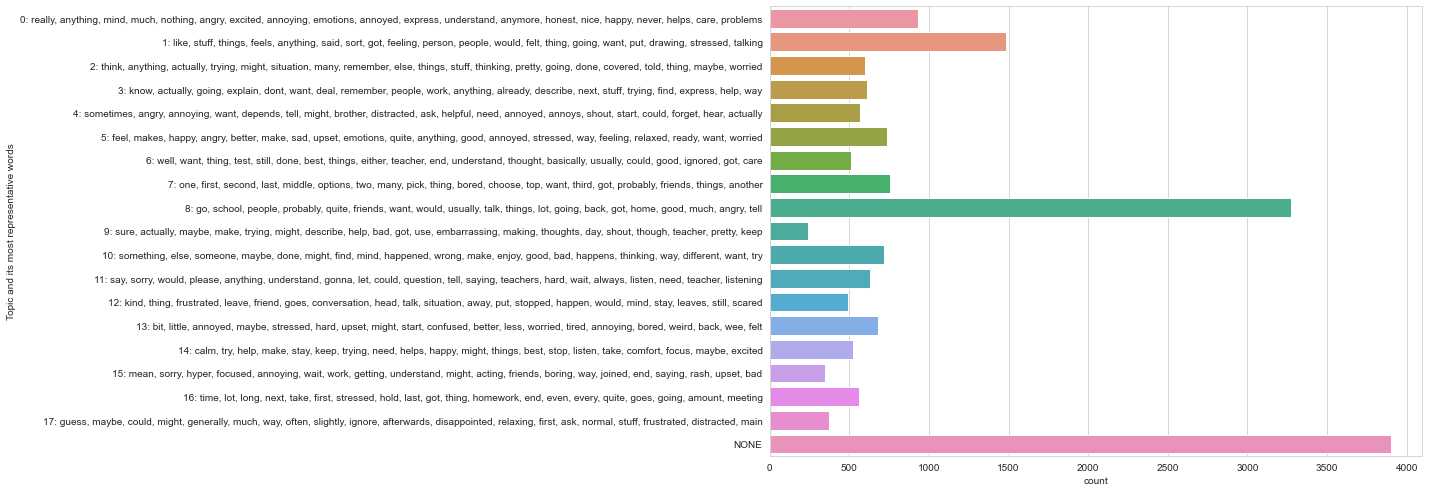

In [53]:
## let's see if the models produce something coherent with the best_k number
no_topics = best_k
## Each topic is represented with a list of words, ranked according to how discriminative they are for that topic. 
## We can use the top ranked words to try to understand what the topic represents.
no_top_words = 20
#lda = getLDAModel(no_topics, document_tfidf)
nmf, W, H = getNMFModel(no_topics, document_tfidf)
result1= display_topics(nmf, feature_names, no_top_words) 
#new_file.write(str(best_k)+','+str(result1)+'\n')
print('Representation of the main topic for each document')
tlist = get_topic_list(nmf,feature_names, no_top_words)
df_result = display_topic_representation(W,df,tlist)

In [54]:
df_result.head()

,ids,diagnosis,section,pilot_number,inter_time,response,Nresponse,LIWC_response,index,topic0,...,topic10,topic11,topic12,topic13,topic14,topic15,topic16,topic17,Topic most represented,Topic and its most representative words
9205,9205,ADHD,Activity Three,Pilot59_10_03_2022,[00:01:37],I don't no not really I don't.,True,not really,9205,0.106973,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0,"0: really, anything, mind, much, nothing, angr..."
12731,12731,ASD,Activity Three,939_03_07_2022,[00:36:28],Not really.,False,NaN,12731,0.106973,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0,"0: really, anything, mind, much, nothing, angr..."
4713,4713,ADHD,Activity Four,917_29_06_2022,[00:42:17],I don't really mind because it's his choice r...,True,really because his choice,4713,0.056326,...,0.001134,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0,"0: really, anything, mind, much, nothing, angr..."
4710,4710,ADHD,Activity Four,917_29_06_2022,[00:42:17],There's not much I can do. I can't really do a...,True,not can't really he'll not,4710,0.019232,...,0.000000,0.000805,0.000246,0.0,0.000106,0.0,0.0,0.00009,0,"0: really, anything, mind, much, nothing, angr..."
16224,16224,ASD,Activity Two,176_18_04_2022,[00:08:57],I like showing it with my mum but not really ...,True,showing mum but not really,16224,0.022150,...,0.011623,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0,"0: really, anything, mind, much, nothing, angr..."


In [58]:
df_result.tail()

,ids,diagnosis,section,pilot_number,inter_time,response,Nresponse,LIWC_response,index,topic0,...,topic10,topic11,topic12,topic13,topic14,topic15,topic16,topic17,Topic most represented,Topic and its most representative words
7226,7226,ADHD,Activity Two,089_11_04_2022,[00:31:43],Okay.,False,NaN,7226,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19,NONE
7228,7228,ADHD,Activity Three,089_11_04_2022,[00:33:31],Okay.,False,NaN,7228,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19,NONE
7230,7230,ADHD,Activity Three,089_11_04_2022,[00:33:56],Yeah.,False,NaN,7230,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19,NONE
7203,7203,ADHD,Activity Two,089_11_04_2022,[00:22:25],Yeah,False,NaN,7203,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19,NONE
0,0,ASD.ADHD,Activity Three,974_16_06_2022,[00:00:14],Yeah.,False,NaN,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19,NONE


In [55]:
print(df_result.columns)

Index(['ids', 'diagnosis', 'section', 'pilot_number', 'inter_time', 'response',
       'Nresponse', 'LIWC_response', 'index', 'topic0', 'topic1', 'topic2',
       'topic3', 'topic4', 'topic5', 'topic6', 'topic7', 'topic8', 'topic9',
       'topic10', 'topic11', 'topic12', 'topic13', 'topic14', 'topic15',
       'topic16', 'topic17', 'Topic most represented',
       'Topic and its most representative words'],
      dtype='object')


In [59]:
print(df_result.shape)

(17953, 29)


In [60]:
new_result = df_result[df_result['Topic and its most representative words'] !='NONE']
print(new_result.shape)

(14050, 29)


In [61]:
new_df = new_result[['ids', 'diagnosis','section', 'pilot_number', 'inter_time', 'response','LIWC_response','Topic most represented', 'Topic and its most representative words']]

In [62]:
#!pip install xlwt
import xlwt
new_df.to_excel('All interviewees responses and the corresponding representative words_withoutNONE.xlsx',index=False)